In [1]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import lax, random, vmap
from jax.scipy.special import logsumexp
import flax
from flax.linen import *

import numpyro
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import handlers
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoDelta, AutoLowRankMultivariateNormal
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.util import find_stack_level, not_jax_tracer
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# データの確認

新生児の体重を妊娠週数と性別で回帰することを考える。

In [2]:
data = pd.DataFrame({
    
    'weeks':[36, 38, 39, 41, 37, 38, 40, 40, 38, 41, 38, 38, 40, 40, 36, 39, 40,
       35, 39, 38, 37, 43, 39, 39, 40, 40, 37, 38, 39, 38, 40, 40, 42, 37,
       41, 38, 37, 39, 40, 40, 38, 41, 38, 37, 39, 39, 43, 38, 38, 38],
    
    'weight':[2980, 2707, 3049, 3429, 2500, 2845, 3071, 3435, 3058, 3123, 3215,
       2902, 3015, 2983, 2727, 3121, 3114, 2511, 3327, 2864, 2749, 3621,
       2860, 3074, 3234, 3083, 2797, 3025, 3129, 2990, 3035, 2990, 3513,
       2687, 3380, 2863, 2715, 3012, 3083, 2938, 2837, 3455, 3175, 2646,
       2889, 2975, 3474, 3052, 3167, 2762],
    
    'gender':[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1]
})

In [3]:
data.head()

,weeks,weight,gender
0,36,2980,0
1,38,2707,1
2,39,3049,1
3,41,3429,1
4,37,2500,1


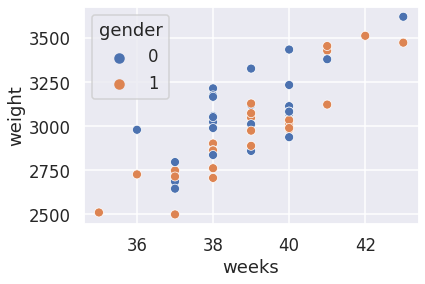

In [4]:
sns.scatterplot(data=data,x="weeks",y="weight",hue="gender");

In [26]:
for c in ["weeks", "weight"]:
    data[f"{c}_scaled"] = (data[f"{c}"] - data[f"{c}"].mean())/data[f"{c}"].std()
x_scaled = data["weeks_scaled"].values
y_scaled = data["weight_scaled"].values
gender = data["gender"].values

# 男女差を考慮しないモデル

In [18]:
def model(x_scaled=None, y_scaled=None, N=0):
    a = numpyro.sample("a", dist.Normal(0,10))
    b = numpyro.sample("b", dist.Normal(0,10))

    mu = numpyro.deterministic("mu", a*x_scaled+b)

    std = numpyro.sample("std", dist.HalfCauchy(5))

    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Normal(mu, std), obs=y_scaled)

nuts = NUTS(model)
mcmc = MCMC(nuts,num_warmup=1000, num_samples=5000, num_chains=4)

mcmc.run(random.PRNGKey(0), x_scaled=x_scaled, y_scaled=y_scaled,N=len(y_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:01<00:00, 5709.64it/s, 7 steps of size 6.67e-01. acc. prob=0.94]


In [19]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

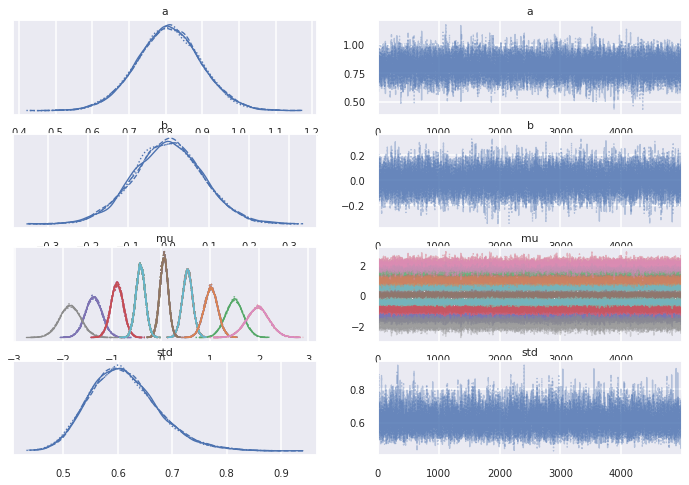

In [20]:
az.plot_trace(idata);

In [21]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.808,0.088,0.643,0.974,0.001,0.000,17195.0,13333.0,1.0
b,-0.001,0.087,-0.174,0.156,0.001,0.001,17504.0,13383.0,1.0
mu[0],-1.382,0.172,-1.712,-1.061,0.001,0.001,17132.0,13684.0,1.0
mu[1],-0.423,0.098,-0.610,-0.242,0.001,0.001,17434.0,13362.0,1.0
mu[2],0.056,0.087,-0.114,0.215,0.001,0.001,17520.0,13575.0,1.0
mu[3],1.015,0.141,0.746,1.275,0.001,0.001,17638.0,13507.0,1.0
mu[4],-0.903,0.130,-1.158,-0.667,0.001,0.001,17239.0,14112.0,1.0
mu[5],-0.423,0.098,-0.610,-0.242,0.001,0.001,17434.0,13362.0,1.0
mu[6],0.536,0.105,0.341,0.739,0.001,0.001,17678.0,12955.0,1.0
mu[7],0.536,0.105,0.341,0.739,0.001,0.001,17678.0,12955.0,1.0


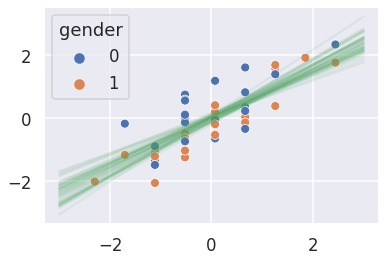

In [22]:
def plot_lines(trace):
    
    samples_to_plot = 50

    x_scaled_new = np.linspace(-3, 3, 50)
        
    for k in range(1, samples_to_plot):
        
        a_sample = trace['a'][-k]
        b_sample = trace['b'][-k]
    
        mu = a_sample * x_scaled_new + b_sample
        
        plt.plot(x_scaled_new, mu, c='g', alpha=0.1)
        
sns.scatterplot(x=x_scaled, y=y_scaled, hue=data['gender'], s=80)
plot_lines(mcmc_samples);

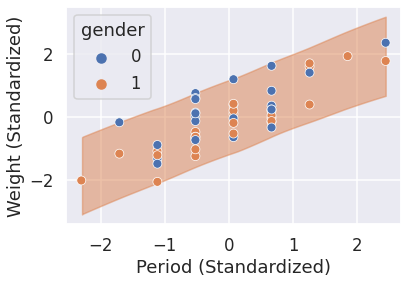

In [25]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(random.PRNGKey(1), x_scaled=x_scaled, N=len(y_scaled))
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

az.plot_hdi(x_scaled, idata_ppc.posterior_predictive['obs'])
sns.scatterplot(x=x_scaled, y=y_scaled, hue=data['gender'], s=80)

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)');

# 男女別々に回帰するモデル

In [46]:
def model(x_scaled=None, y_scaled=None, gender=None, N=0):
    a = numpyro.sample("a", dist.Normal(0,10), sample_shape=(2,))
    b = numpyro.sample("b", dist.Normal(0,10), sample_shape=(2,))

    mu = numpyro.deterministic("mu", a[gender]*x_scaled+b[gender])

    std = numpyro.sample("std", dist.HalfCauchy(5))

    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Normal(mu, std), obs=y_scaled)
    
    a_diff = numpyro.deterministic("a_diff", a[1] - a[0])
    b_diff = numpyro.deterministic("b_diff", b[1] - b[0])

nuts = NUTS(model)
mcmc = MCMC(nuts,num_warmup=1000, num_samples=5000, num_chains=4)

mcmc.run(random.PRNGKey(0), x_scaled=x_scaled, y_scaled=y_scaled,gender=gender,N=len(y_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:00<00:00, 6751.84it/s, 7 steps of size 7.45e-01. acc. prob=0.88]


In [47]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

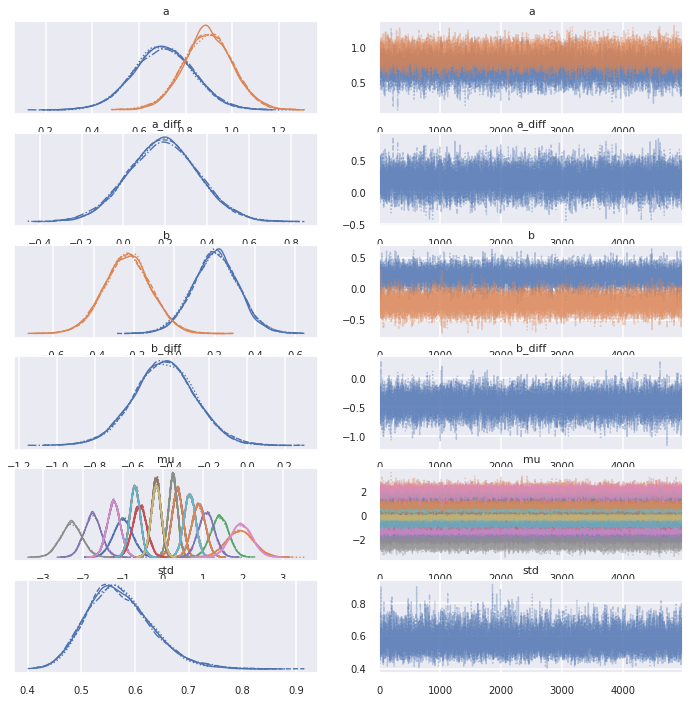

In [48]:
az.plot_trace(idata);

In [49]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.705,0.129,0.460,0.945,0.001,0.001,24392.0,15302.0,1.0
a[1],0.895,0.106,0.688,1.086,0.001,0.000,25506.0,14531.0,1.0
a_diff,0.190,0.167,-0.122,0.508,0.001,0.001,25029.0,15275.0,1.0
b[0],0.204,0.114,-0.019,0.414,0.001,0.001,26723.0,14947.0,1.0
b[1],-0.232,0.117,-0.455,-0.014,0.001,0.001,22500.0,14173.0,1.0
b_diff,-0.436,0.164,-0.747,-0.127,0.001,0.001,24996.0,14679.0,1.0
mu[0],-0.999,0.242,-1.452,-0.543,0.002,0.001,25127.0,15371.0,1.0
mu[1],-0.699,0.131,-0.955,-0.460,0.001,0.001,22560.0,14235.0,1.0
mu[2],-0.168,0.117,-0.388,0.051,0.001,0.001,22571.0,13904.0,1.0
mu[3],0.894,0.174,0.561,1.211,0.001,0.001,25555.0,15051.0,1.0


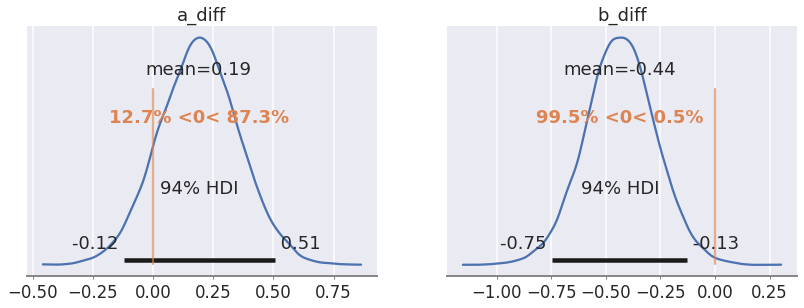

In [50]:
az.plot_posterior(idata, var_names=["a_diff", "b_diff"], ref_val=0);

切片は有意に差がありそうだが傾きは差があるか微妙。

In [51]:
idata.to_netcdf("./result_data/babies_model2.nc")

'./result_data/babies_model2.nc'

# 切片にだけ差があるモデル

In [52]:
def model(x_scaled=None, y_scaled=None, gender=None, N=0):
    a = numpyro.sample("a", dist.Normal(0,10), sample_shape=(1,))
    b = numpyro.sample("b", dist.Normal(0,10), sample_shape=(2,))

    mu = numpyro.deterministic("mu", a*x_scaled+b[gender])

    std = numpyro.sample("std", dist.HalfCauchy(5))

    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Normal(mu, std), obs=y_scaled)
    
    b_diff = numpyro.deterministic("b_diff", b[1] - b[0])

nuts = NUTS(model)
mcmc = MCMC(nuts,num_warmup=1000, num_samples=5000, num_chains=4)

mcmc.run(random.PRNGKey(0), x_scaled=x_scaled, y_scaled=y_scaled,gender=gender,N=len(y_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:00<00:00, 6951.99it/s, 3 steps of size 5.66e-01. acc. prob=0.95]


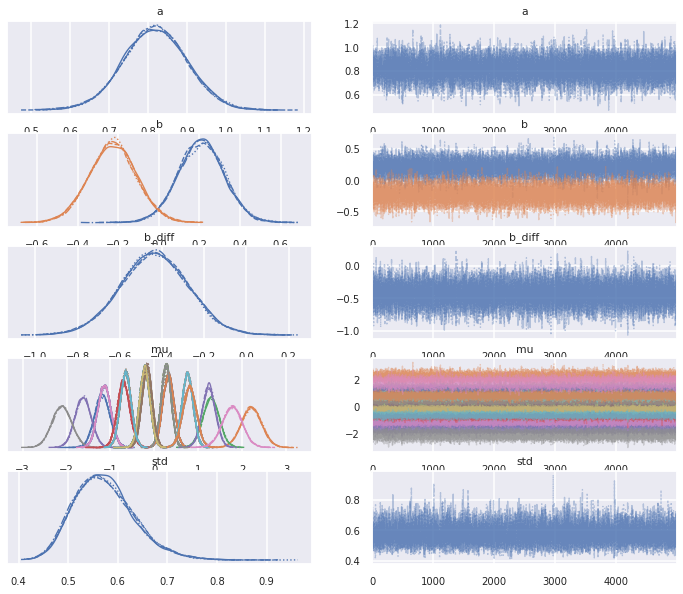

In [53]:
az.plot_trace(idata);

In [54]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.817,0.082,0.667,0.979,0.001,0.000,22836.0,14821.0,1.0
b[0],0.209,0.114,-0.004,0.421,0.001,0.001,22614.0,14062.0,1.0
b[1],-0.227,0.117,-0.447,-0.007,0.001,0.001,22391.0,14076.0,1.0
b_diff,-0.436,0.162,-0.743,-0.135,0.001,0.001,23458.0,14708.0,1.0
mu[0],-1.187,0.178,-1.515,-0.846,0.001,0.001,23137.0,14625.0,1.0
mu[1],-0.654,0.125,-0.882,-0.409,0.001,0.001,22071.0,13827.0,1.0
mu[2],-0.169,0.117,-0.387,0.053,0.001,0.001,22446.0,13651.0,1.0
mu[3],0.801,0.154,0.509,1.086,0.001,0.001,23291.0,14786.0,1.0
mu[4],-1.138,0.150,-1.411,-0.847,0.001,0.001,22022.0,14300.0,1.0
mu[5],-0.654,0.125,-0.882,-0.409,0.001,0.001,22071.0,13827.0,1.0


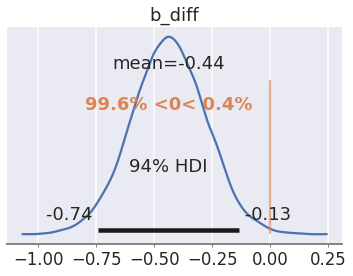

In [55]:
az.plot_posterior(idata, var_names=["b_diff"], ref_val=0);

In [56]:
idata.to_netcdf("./result_data/babies_model3.nc")

'./result_data/babies_model3.nc'

## 情報量基準でモデルを比較

In [57]:
idata2 = az.from_netcdf("result_data/babies_model2.nc")
idata3 = az.from_netcdf("result_data/babies_model3.nc")

In [60]:
idata_dict = {"Slope is same.":idata3, "Slope is different.":idata2}

In [63]:
df_waic = az.compare(idata_dict, ic="waic", scale="deviance")
df_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Slope is same.,0,88.257644,3.273314,0.00000,0.766423,7.631292,0.000000,False,deviance
Slope is different.,1,89.019514,4.211574,0.76187,0.233577,6.975073,2.399093,True,deviance


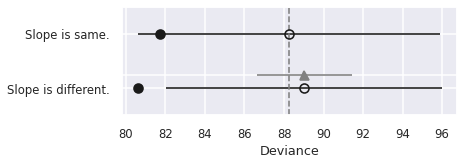

In [64]:
az.plot_compare(df_waic);

In [67]:
df_loo = az.compare(idata_dict, ic="loo", scale="deviance")

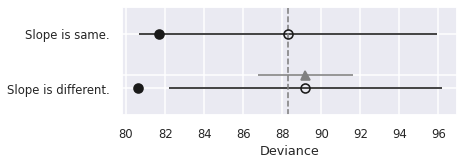

In [68]:
az.plot_compare(df_loo);

In [69]:
predictive = Predictive(model, mcmc_samples)

In [76]:
x_new = np.arange(35, 44)
x_scaled_new = (x_new - data["weeks"].mean()) / data["weeks"].std()
gender_new = np.zeros_like(x_new, dtype=int)

In [77]:
ppc_samples = predictive(random.PRNGKey(1), x_scaled=x_scaled_new, gender=gender_new, N=len(x_scaled_new))
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [81]:
obs_pred = idata_ppc.posterior_predictive["obs"]
obs_mean = obs_pred.mean(axis=0).mean(axis=0) # chainごとの平均→サンプルごとの平均

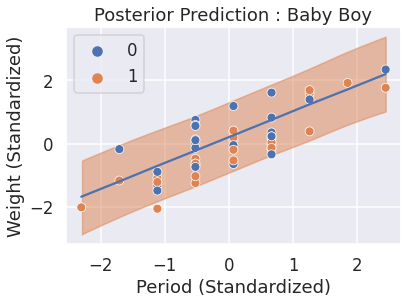

In [82]:
# 事後予測分布の表示
az.plot_hdi(x_scaled_new, obs_pred)
plt.plot(x_scaled_new, obs_mean)

# 観測データの表示
sns.scatterplot(x=x_scaled, y=y_scaled, hue=gender, s=80)

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)')
plt.title('Posterior Prediction : Baby Boy');

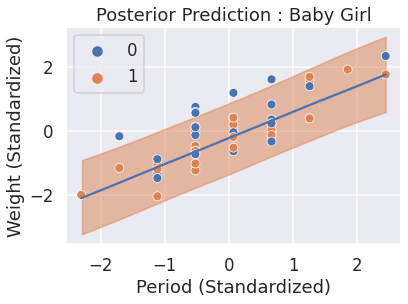

In [84]:
# Case Girl
gender_new = np.ones_like(x_new, dtype=int)
ppc_samples = predictive(random.PRNGKey(1), x_scaled=x_scaled_new, gender=gender_new, N=len(x_scaled_new))
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)
obs_pred = idata_ppc.posterior_predictive['obs']
obs_mean = obs_pred.mean(axis=0).mean(axis=0)
# 事後予測分布の表示
az.plot_hdi(x_scaled_new, obs_pred)
plt.plot(x_scaled_new, obs_mean)

# 観測データの表示
sns.scatterplot(x=x_scaled, y=y_scaled, hue=gender, s=80)

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)')
plt.title('Posterior Prediction : Baby Girl');